In [3]:
# importeer libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels
import scipy
from scipy.stats import norm
import math
import numpy as np
import statsmodels.tsa.seasonal
import statsmodels.graphics.tsaplots
import matplotlib
import lifelines


In [9]:
df = pd.read_csv('helpdesk.csv')
df["start_date"] = pd.to_datetime(df["start_date"], format="%Y-%m-%d")
df["end_date"]   = pd.to_datetime(df["end_date"],   format="%Y-%m-%d", errors="coerce")

In [36]:
df['experience_cat']


0       medium
1       medium
2          low
3          low
4       medium
         ...  
8110    medium
8111    medium
8112       low
8113      high
8114    medium
Name: experience_cat, Length: 8115, dtype: object

In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_date      8115 non-null   datetime64[ns]
 1   priority        8115 non-null   object        
 2   experience_cat  8115 non-null   object        
 3   team_size       8115 non-null   int64         
 4   budget          8115 non-null   int64         
 5   type            8115 non-null   object        
 6   status          8115 non-null   object        
 7   end_date        6846 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 507.3+ KB


In [38]:
df_ibs = pd.DataFrame()

df_ibs = pd.get_dummies(df, columns=['priority', 'experience_cat', 'type'], drop_first=False)
df_ibs["Event"] = df["status"].map({'completed': 1, 'ongoing': 0, 'cancelled': 0})
df_ibs['Censoring'] = df['status'] == 'cancelled'
df_ibs['team_size'] = df['team_size']
df_ibs['budget'] = df['budget']

df_ibs["stop_date"] = df_ibs["end_date"]
cutoff = df_ibs["start_date"].max()  # of een vaste datum, of df_ibs["start_date"].max()

df_ibs.loc[df_ibs["stop_date"].isna(), "stop_date"] = cutoff
df_ibs["Survival_time"] = (df_ibs["stop_date"] - df_ibs["start_date"]).dt.days


df_ibs[2000:2015]

,start_date,team_size,budget,status,end_date,priority_high,priority_low,priority_medium,experience_cat_high,experience_cat_low,experience_cat_medium,type_bug,type_chore,type_doc,type_feature,Event,Censoring,stop_date,Survival_time
2000,2025-06-07,10,51400,completed,2025-06-15,False,True,False,False,False,True,True,False,False,False,1,False,2025-06-15,8
2001,2025-06-07,7,62700,completed,2025-07-21,False,True,False,False,True,False,True,False,False,False,1,False,2025-07-21,44
2002,2025-06-07,4,47900,completed,2025-06-30,False,False,True,False,True,False,False,False,False,True,1,False,2025-06-30,23
2003,2025-06-07,6,41600,completed,2025-06-20,False,False,True,False,True,False,True,False,False,False,1,False,2025-06-20,13
2004,2025-06-07,7,45900,completed,2025-06-29,False,False,True,False,True,False,False,False,False,True,1,False,2025-06-29,22
2005,2025-06-07,4,35900,completed,2025-06-24,True,False,False,False,False,True,True,False,False,False,1,False,2025-06-24,17
2006,2025-06-07,4,48300,completed,2025-06-29,False,False,True,False,True,False,True,False,False,False,1,False,2025-06-29,22
2007,2025-06-07,7,50300,completed,2025-07-03,True,False,False,False,False,True,False,False,False,True,1,False,2025-07-03,26
2008,2025-06-07,6,41600,completed,2025-07-02,True,False,False,False,True,False,True,False,False,False,1,False,2025-07-02,25
2009,2025-06-07,5,79900,completed,2025-07-03,False,False,True,False,True,False,True,False,False,False,1,False,2025-07-03,26


In [39]:
df_ibs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   start_date             8115 non-null   datetime64[ns]
 1   team_size              8115 non-null   int64         
 2   budget                 8115 non-null   int64         
 3   status                 8115 non-null   object        
 4   end_date               6846 non-null   datetime64[ns]
 5   priority_high          8115 non-null   bool          
 6   priority_low           8115 non-null   bool          
 7   priority_medium        8115 non-null   bool          
 8   experience_cat_high    8115 non-null   bool          
 9   experience_cat_low     8115 non-null   bool          
 10  experience_cat_medium  8115 non-null   bool          
 11  type_bug               8115 non-null   bool          
 12  type_chore             8115 non-null   bool          
 13  typ

In [50]:
cph = lifelines.CoxPHFitter()
cph.fit(df_ibs, "Survival_time", "Event",
        formula="team_size + budget + priority_high + priority_medium + experience_cat_medium + experience_cat_high + type_bug + type_chore + type_doc")


<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>

In [51]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53959.80
         time fit was run = 2026-01-08 09:18:09 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
team_size              -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
budget                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
priority_high           0.07       1.07       0.03             0.00             0.14                 1.00                 1.15
priority_medium         0.04       1.04       0.03            -0.02             0.10                 0.98                 1.10
experience_cat_medium   0.07       1.08       0.03             0.02             0.13                 1.02                 1.14
experience_cat_high     0.08       1.08       0.04             0.01             0.15                 1.01                 1.16
type_bug                0.03       1.03       0.03            -0.02             0.08                 0.98                 1.09
type_chore              0.08       1.08       0.04             0.01             0.15                 1.01                 1.16
type_doc               -0.03       0.97       0.06            -0.15             0.08                 0.86                 1.09

                        cmp to     z    p   -log2(p)
covariate                                           
team_size                 0.00 -0.23 0.82       0.29
budget                    0.00 -0.30 0.76       0.39
priority_high             0.00  2.09 0.04       4.76
priority_medium           0.00  1.28 0.20       2.31
experience_cat_medium     0.00  2.63 0.01       6.89
experience_cat_high       0.00  2.25 0.02       5.36
type_bug                  0.00  1.14 0.25       1.97
type_chore                0.00  2.09 0.04       4.79
type_doc                  0.00 -0.58 0.56       0.82
---
Concordance = 0.50
Partial AIC = 107937.60
log-likelihood ratio test = 18.48 on 9 df
-log2(p) of ll-ratio test = 5.06

<Axes: xlabel='log(HR) (95% CI)'>

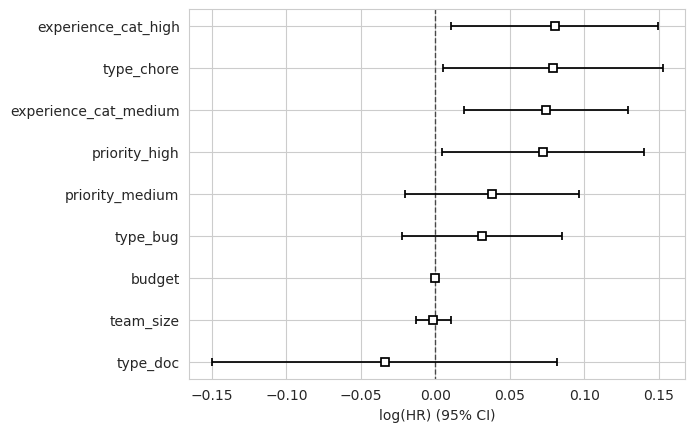

In [52]:
cph.plot()

In [53]:
cph2 = lifelines.CoxPHFitter()
cph2.fit(df_ibs, duration_col='Survival_time', event_col='Event', formula = "priority_high + experience_cat_high + experience_cat_medium + type_chore")

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>

In [54]:
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53961.70
         time fit was run = 2026-01-08 09:18:30 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
priority_high           0.05       1.05       0.03            -0.01             0.10                 0.99                 1.11
experience_cat_high     0.08       1.09       0.04             0.01             0.15                 1.01                 1.16
experience_cat_medium   0.08       1.08       0.03             0.02             0.13                 1.02                 1.14
type_chore              0.07       1.07       0.03            -0.00             0.13                 1.00                 1.14

                        cmp to    z    p   -log2(p)
covariate                                          
priority_high             0.00 1.65 0.10       3.34
experience_cat_high       0.00 2.31 0.02       5.60
experience_cat_medium     0.00 2.69 0.01       7.12
type_chore                0.00 1.91 0.06       4.14
---
Concordance = 0.49
Partial AIC = 107931.39
log-likelihood ratio test = 14.68 on 4 df
-log2(p) of ll-ratio test = 7.53

<Axes: xlabel='log(HR) (95% CI)'>

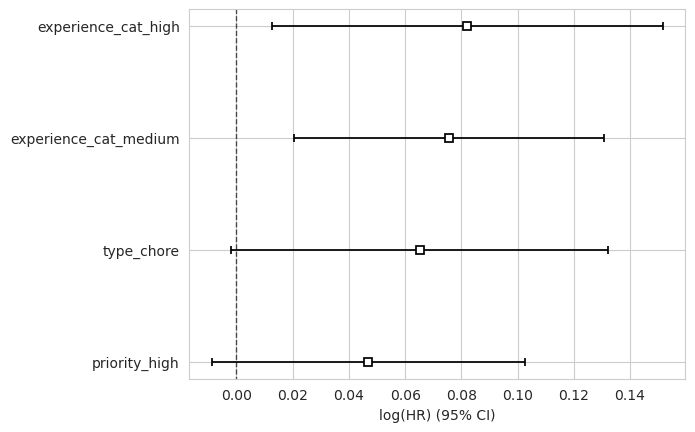

In [55]:
cph2.plot()

In [56]:
cph3 = lifelines.CoxPHFitter()
cph3.fit(df_ibs, duration_col='Survival_time', event_col='Event', formula = "experience_cat_high + experience_cat_medium")

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>

In [57]:
cph3.print_summary()

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53964.78
         time fit was run = 2026-01-08 09:18:42 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
experience_cat_high     0.08       1.08       0.04             0.01             0.15                 1.01                 1.16
experience_cat_medium   0.08       1.08       0.03             0.02             0.13                 1.02                 1.14

                        cmp to    z    p   -log2(p)
covariate                                          
experience_cat_high       0.00 2.30 0.02       5.53
experience_cat_medium     0.00 2.69 0.01       7.12
---
Concordance = 0.49
Partial AIC = 107933.56
log-likelihood ratio test = 8.51 on 2 df
-log2(p) of ll-ratio test = 6.14

<Axes: xlabel='log(HR) (95% CI)'>

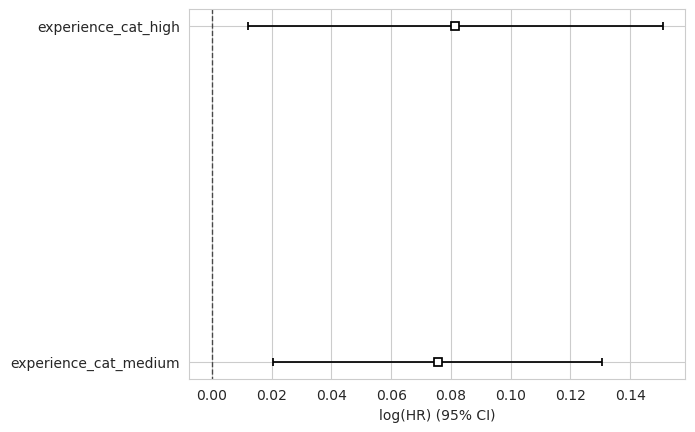

In [58]:
cph3.plot()